In [22]:
# Step 1: Data Loading (Equivalent to data.py)
# Load the Iris dataset
# Import all necessary libraries
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
def load_iris_data():
    iris = fetch_ucirepo(id=53)
    X = iris.data.features
    y = iris.data.targets

    # Clean target labels
    y = y.replace('Iris-', '', regex=True)

    # Convert to numpy arrays and flatten y
    return X.values, y.values.ravel()   # <--- ravel() fixes the 2D->1D issue

# Load the Wine dataset (for later)
def load_wine_data():
    wine = fetch_ucirepo(id=109)
    X = wine.data.features
    y = wine.data.targets
    return X.values, y.values

In [23]:
#Step 2: Utility Function (Equivalent to utils.py)
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    split = int((1 - test_size) * X.shape[0])
    train_idx, test_idx = indices[:split], indices[split:]
    
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

In [24]:
# Step 3: KNN Classifier (Modified to handle numpy arrays)
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.label_mapping = {}  # For encoding labels
        self.reverse_mapping = {}  # For decoding predictions

    def fit(self, X_train, y_train):
        self.X_train = X_train
        # Convert labels to Python native types if they're numpy arrays
        y_train = np.array([int(label.item()) if isinstance(label, np.ndarray) else label 
                           for label in y_train])
        
        # Create label mapping for labels
        unique_labels = np.unique(y_train)
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.reverse_mapping = {idx: label for label, idx in self.label_mapping.items()}
        
        # Encode labels
        self.y_train = np.array([self.label_mapping[label] for label in y_train])

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        # Decode predictions back to original labels
        return np.array([self.reverse_mapping[p] for p in predictions])

    def _predict(self, x):
        # Compute distances to all training points
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train[k_indices]
        # Majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [25]:
#Step 4: Exploratory Data Analysis (Equivalent to eda.py)
def plot_iris_eda(X, y):
    df = pd.DataFrame(X, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
    df["species"] = y

    features = df.columns[:-1]
    n = len(features)

    plt.figure(figsize=(10, 10))
    for i in range(n):
        for j in range(i+1, n):
            plt.subplot(n-1, n-1, i*(n-1) + j)
            for species in df["species"].unique():
                subset = df[df["species"] == species]
                plt.scatter(subset[features[i]], subset[features[j]], label=species)
            plt.xlabel(features[i])
            plt.ylabel(features[j])
    plt.legend()
    plt.suptitle("Pairwise Feature Scatter Plots - Iris Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

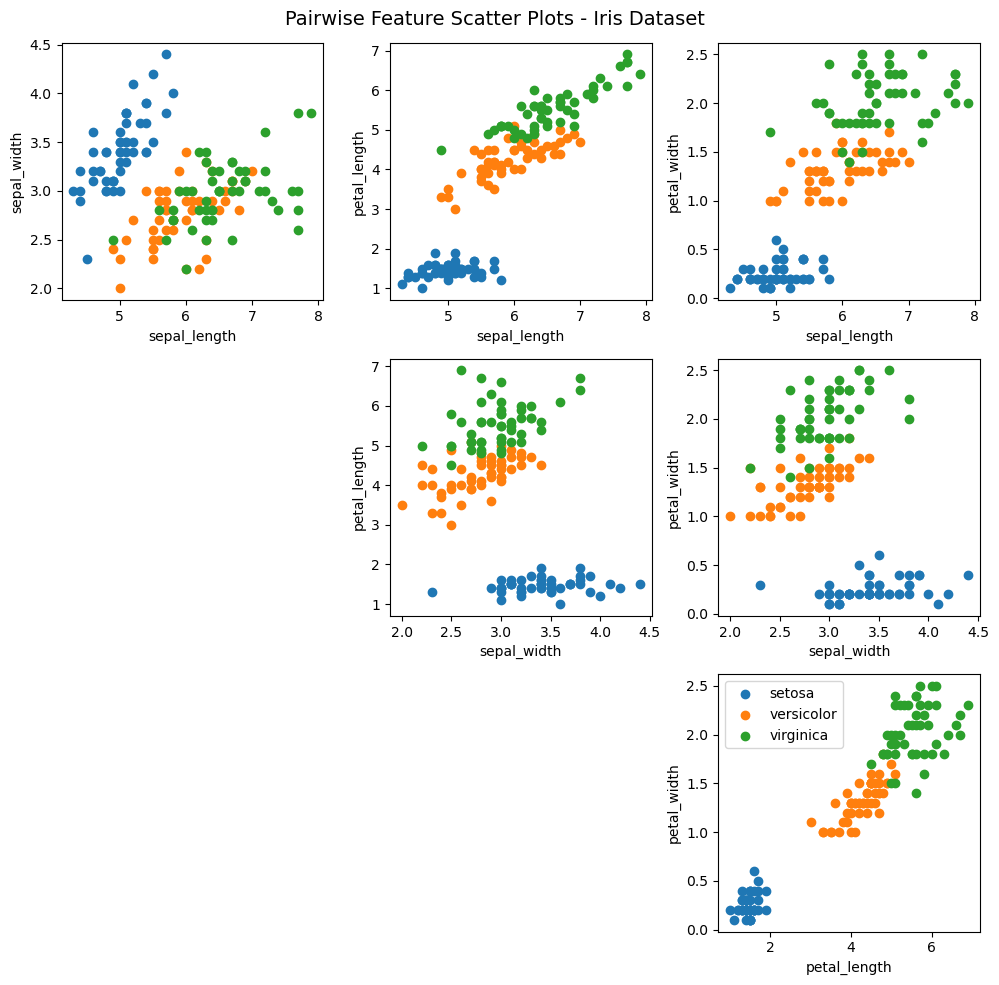

✅ Accuracy (k=3) on Iris dataset: 96.67%


In [26]:
# Step 5: Model Training, Evaluation, and Tuning (Equivalent to main.py)
# Load data
X, y = load_iris_data()

# EDA
plot_iris_eda(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train & evaluate for k = 3
model = KNNClassifier(k=3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"✅ Accuracy (k=3) on Iris dataset: {accuracy * 100:.2f}%")

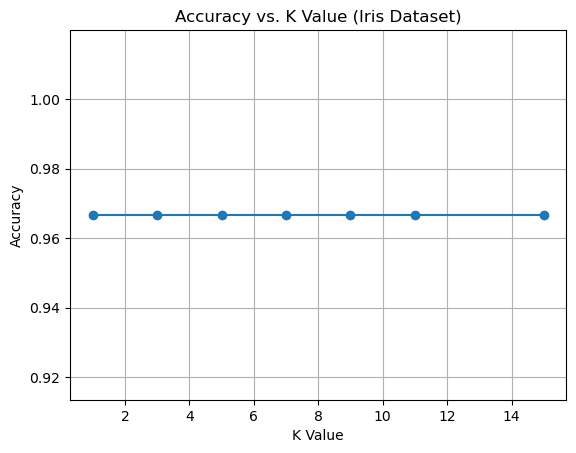

🏆 Best k = 1 with accuracy = 96.67%


In [27]:
# Step 6: Hyperparameter Analysis (Accuracy vs. k)
k_values = [1, 3, 5, 7, 9, 11, 15]
accuracies = []

for k in k_values:
    model = KNNClassifier(k=k)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = np.sum(preds == y_test) / len(y_test)
    accuracies.append(acc)

plt.plot(k_values, accuracies, marker='o')
plt.title("Accuracy vs. K Value (Iris Dataset)")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"🏆 Best k = {best_k} with accuracy = {max(accuracies)*100:.2f}%")


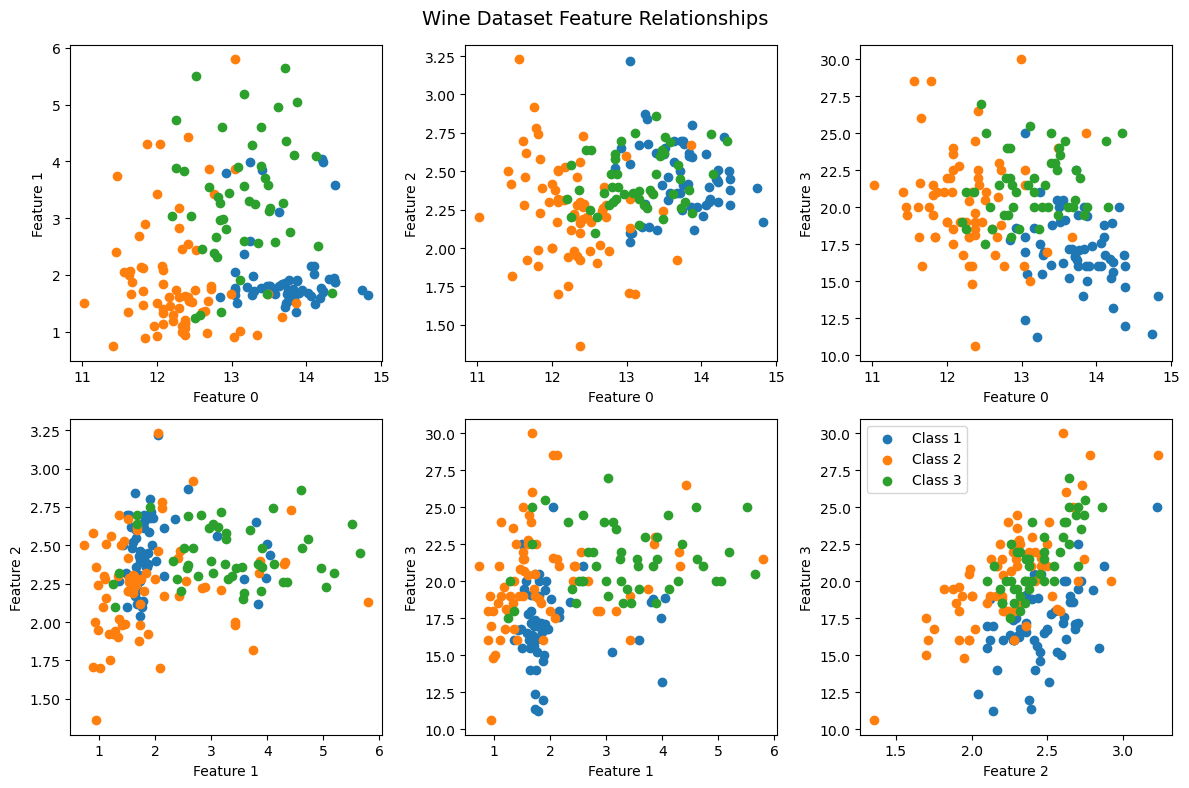

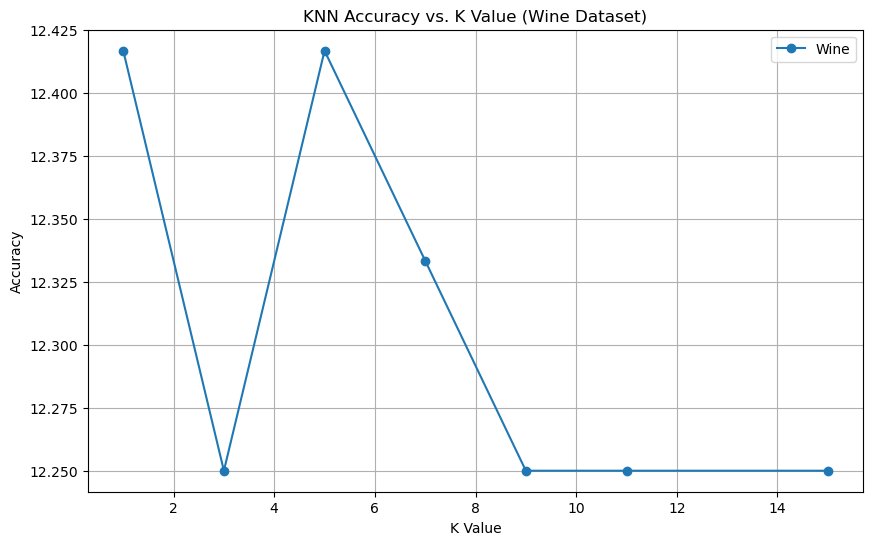

In [31]:
#Step 7: Generalization to Wine Dataset
# Load and visualize Wine data
X_wine, y_wine = load_wine_data()

# Visualize Wine dataset
plot_wine_eda(X_wine, y_wine)

# Split Wine data
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
    X_wine, y_wine, test_size=0.2, random_state=42
)

# Train model with best k from Iris analysis
model = KNNClassifier(k=best_k)
model.fit(X_train_wine, y_train_wine)
predictions = model.predict(X_test_wine)

# Calculate and display accuracy
wine_acc = np.sum(predictions == y_test_wine) / len(y_test_wine)

# Compare different k values for Wine dataset
wine_accuracies = []
for k in k_values:
    model = KNNClassifier(k=k)
    model.fit(X_train_wine, y_train_wine)
    preds = model.predict(X_test_wine)
    acc = np.sum(preds == y_test_wine) / len(y_test_wine)
    wine_accuracies.append(acc)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(k_values, wine_accuracies, marker='o', label='Wine')
plt.title("KNN Accuracy vs. K Value (Wine Dataset)")
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

